**Raccomandazione di serie o film anime utilizzando i giudizi degli utenti di myanimelist**

Progetto per il corso di Programmazione di Applicazioni Data Intensive

Francesco Padovani

Librerie non predefinite in colab da installare

In [ ]:
%pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633998 sha256=b58a6f926a46b1c4a14a63b7e2442aa1b853143c614f057ae630d7d6fb1321bf
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import surprise
import os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!unzip "/content/rating.zip" -d "/content/data"


Archive:  /content/rating.zip
  inflating: /content/data/rating.csv  


## Parte 1- Descrizione del problema e analisi esplorativa

Si cerca di realizzare un modello in grado di fornire raccomandazioni significative agli utenti. 

Datasets

Sono presenti due dataset: anime.csv e rating.csv. 

anime.csv contiene le seguenti informazioni:


*  **anime_id**: l'id univoco associato al prodotto
*   **name**: il nome del prodotto
*  **genre**: il genere televisivo del prodotto
* **type**: se si tratta di una serie tv o un film
* **episodes**: il numero di episodi
* **rating**: il rating medio del prodotto
* **members**: il numero di utenti che ha guardato il prodotto




In [ ]:
anime_raw = pd.read_csv("/content/anime.csv")
anime_raw.drop("Unnamed: 0" , axis=1, inplace=True)
anime_raw.genre.fillna("NULL",inplace=True)
anime_raw.head(5)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


rating.csv contiene invece:


*   **user_id**: l'id univoco di un utente
*   **anime_id**: l'id univoco di un prodotto
* **rating** : il voto espresso dall'utente verso il prodotto con scala 1-10. è asssegnato -1 ai prodotti visti ma non valutati.






In [ ]:
rating_raw=pd.read_csv("/content/data/rating.csv")
rating_raw.drop("Unnamed: 0" , axis=1, inplace=True) 
rating_raw.head(5)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Analisi Esplorativa

In [ ]:
rating_raw.shape

(7689833, 3)

Sono presenti 7689833 triple utente prodotto voto.

In [ ]:
rating_raw.describe()

,user_id,anime_id,rating
count,7.689833e+06,7.689833e+06,7.689833e+06
mean,3.671195e+04,8.954710e+03,6.171581e+00
std,2.100297e+04,8.911550e+03,3.718885e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.895100e+04,1.222000e+03,6.000000e+00
50%,3.674300e+04,6.325000e+03,7.000000e+00
75%,5.475500e+04,1.422700e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [ ]:
rating_raw= rating_raw.replace(-1,0)

Lavorando con rating espliciti si eliminano i prodotti visualizzati ma non votati. Il voto medio ricevuto da un prodotto è pari a 7.82 e la mediana è 8.

In [ ]:
rating_explicit= rating_raw[rating_raw['rating']>0]
rating_explicit.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [ ]:
rating_explicit.describe()

,user_id,anime_id,rating
count,6.249526e+06,6.249526e+06,6.249526e+06
mean,3.673124e+04,8.942848e+03,7.824390e+00
std,2.102229e+04,8.905665e+03,1.559628e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.895800e+04,1.222000e+03,7.000000e+00
50%,3.677500e+04,6.325000e+03,8.000000e+00
75%,5.487300e+04,1.422700e+04,9.000000e+00
max,7.351600e+04,3.447500e+04,1.000000e+01


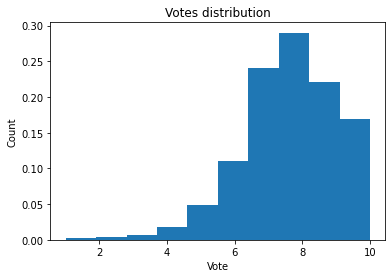

In [ ]:
data=rating_explicit['rating']
plt.xlabel('Vote')
plt.ylabel('Count')
plt.title('Votes distribution')
plt.hist(data,bins=10,density=True) #densità di probabilità che un utente abbia assegnato voto x
plt.show()

Analizziamo quanti voti sono presenti nella utility matrix, quanti diversi utenti hanno votato e quanti prodotti sono stati votati

Hanno votato 69516 utenti diversi con una media di prodotti votati per utente di 89.9

In [ ]:
rating_explicit['user_id'].value_counts().describe()

count    69516.000000
mean        89.900541
std        132.837710
min          1.000000
25%         13.000000
50%         44.000000
75%        113.000000
max       3529.000000
Name: user_id, dtype: float64

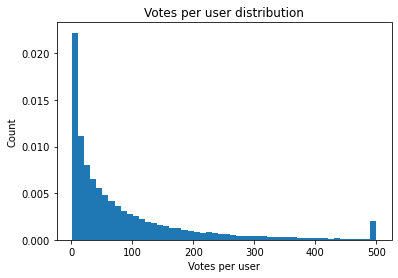

In [ ]:
data=rating_explicit.groupby('user_id')['rating'].count().clip(upper=500)
plt.xlabel('Votes per user')
plt.ylabel('Count')
plt.title('Votes per user distribution')
plt.hist(data,bins=50,density=True) #densità di probabilità che un utente abbia effettuato x voti
plt.show()

In [ ]:
rating_explicit['anime_id'].value_counts().describe()

count     8810.00000
mean       709.36731
std       1893.65342
min          1.00000
25%          7.00000
50%         67.00000
75%        495.75000
max      34226.00000
Name: anime_id, dtype: float64

Sono stati votati 8810 diversi prodotti con una media di voti ricevuti per prodotto di 709.36. Si nota il cosiddetto fenomeno della "long tail" per cui solo una piccola parte dei prodotti ha ricevuto la maggior parte dei voti.

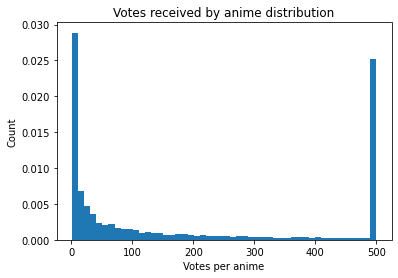

In [ ]:
data=rating_explicit.groupby('anime_id')['rating'].count().clip(upper=500)
plt.xlabel('Votes per anime')
plt.ylabel('Count')
plt.title('Votes received by anime distribution')
plt.hist(data,bins=50,density=True) #densità di probabilità che un anime abbia ricevuto x voti
plt.show()

Si può notare vedendo le figure prodotte che sia il numero di voti effettuati dagli utenti, sia il numero di voti ricevuti dai prodotti non hanno distribuzione normale. Si utilizza quindi la mediana come indice di posizione più rilevante.

In [ ]:
print('mediana dei voti effettuati dagli utenti: ', rating_explicit['user_id'].value_counts().median())
print('mediana dei voti ricevuti dai prodotti: ', rating_explicit['anime_id'].value_counts().median())

mediana dei voti effettuati dagli utenti:  44.0
mediana dei voti ricevuti dai prodotti:  67.0


## Parte 2: Feature engineering 

### Selezione utenti e prodotti rilevanti

La maggior parte degli utenti ha espresso un numero estremamente limitato di giudizi pertanto si sceglie di escludere quegli utenti con un numero estremamente basso di voti. Si escludono anche i prodotti con un numero estremamente basso di giudizi.

In [ ]:
min_anime_ratings = 1500
filter_anime = rating_explicit['anime_id'].value_counts() > min_anime_ratings
filter_anime = filter_anime[filter_anime].index.tolist()

min_user_ratings = 250
filter_users = rating_explicit['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

rating_new = rating_explicit[(rating_explicit['anime_id'].isin(filter_anime)) & (rating_explicit['user_id'].isin(filter_users))]
print('Dataframe originale:\t{}'.format(rating_explicit.shape))
print('Nuovo Dataframe:\t{}'.format(rating_new.shape))

The original data frame shape:	(6249526, 3)
The new data frame shape:	(1645405, 3)


In [ ]:
rating_new['user_id'].value_counts()

57620    662
45659    649
42635    641
59643    631
8115     594
        ... 
53276     55
7527      52
21568     45
67554     44
23395     34
Name: user_id, Length: 5887, dtype: int64

Eliminiamo anche gli utenti con un numero anomalo di voti

In [ ]:
cap=rating_explicit['user_id'].value_counts().quantile(0.975)
cap

444.0

In [ ]:
filter_cap= rating_explicit['user_id'].value_counts()<cap
filter_cap=filter_cap[filter_cap].index.tolist()
rating_new= rating_new[rating_new['user_id'].isin(filter_cap)]
print('Nuovo Dataframe:\t{}'.format(rating_new.shape))

The new data frame shape:	(966527, 3)


Controllo la presenza di duplicati ed eventualmente li rimuovo.

In [ ]:
dup_rating = rating_new[rating_new.duplicated()].shape[0]
rating_new.drop_duplicates(keep='first',inplace=True)

In [ ]:
rating_new['anime_id'].nunique()

1081

In [ ]:
rating_new['user_id'].nunique()

4143

Creo train e test split

In [ ]:
rating_train,rating_test= sklearn.model_selection.train_test_split(rating_new,test_size=0.25,random_state=42)

In [ ]:
rating_train.shape

(724895, 3)

In [ ]:
rating_test.shape

(241632, 3)

In [ ]:
rating_train.head(10)

,user_id,anime_id,rating
177728,95,280,-0.562556
4155425,2226,631,-0.562556
4372743,2355,1031,0.111987
4231829,2267,580,-0.562556
4886009,2644,795,-0.562556
5973415,3229,327,0.786530
5267894,2848,535,0.786530
7120619,3879,590,-1.237100
3763028,2040,796,0.111987
3347238,1827,610,-1.911643


In [ ]:
rating_train['user_id'].value_counts().describe()


count    4143.000000
mean      174.968622
std        37.226401
min        37.000000
25%       151.000000
50%       174.000000
75%       199.000000
max       301.000000
Name: user_id, dtype: float64

## Parte 3: Modelli di Learning

Partiamo con l'utilizzo della libreria surprise per fare training e confronto di diversi modelli di recommendation.
Per prima cosa importiamo gli algoritmi e le utilities necessarie utilizzati.

In [ ]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, GridSearchCV
from surprise import NormalPredictor,SVD, SlopeOne, NMF,KNNBasic,SVDpp
from surprise.accuracy import rmse,mae
from surprise import accuracy
from surprise.model_selection import train_test_split

Creiamo poi l'oggetto Reader che servirà per leggere la utility matrix e convertiamo il nostro dataframe in un Dataset utilizzabile con surprise

In [ ]:
reader= Reader(rating_scale=(1,10))
dataset_test=Dataset.load_from_df(rating_test,reader)
dataset_train=Dataset.load_from_df(rating_train,reader)

E l'oggetto kf per la k-fold crossvalidation

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
datatrain=dataset_train.build_full_trainset()

In [ ]:
datatest=dataset_test.build_full_trainset().build_testset()

Le misure utilizzate per valutare la bontà del modello saranno MAE e RMSE.

##Normal Predictor
Utilizziamo Normal Predictor, un modello che predice voti casuali con distribuzione normale,per avere una baseline con cui confrontare la bontà dei modelli successivamente addestrati.

In [ ]:
np.random.seed(42)
Normal= NormalPredictor()
Normal.fit(datatrain)

In [ ]:
rpred=Normal.test(datatest)
rmse(rpred),mae(rpred)

RMSE: 2.0326
MAE:  1.6130


(2.0326119639194156, 1.6129973037775212)

Il modello casuale genera un RMSE di 2.0 ed un MAE di 1.6. Useremo questi valori come baseline per valutare la bontà delle predizione dei modelli successivi.

## KNN K-Nearest Neighbor
Il primo modello valutato è KNN che utilizza le informazioni dei K utenti più simili per effettuare una predizione dei gusti dell'utente target.

Cerco gli iperparametri ottimali tramite grid search. Per questioni di tempo di training cerco solo tra 3 valori possibili di k (numero di utenti simili) e utilizzo solo la similarità coseno come misura di similarità in quanto generalmente offre risultati migliori rispetto a Pearson.

In [ ]:
gridknn = {"k": [5,25,40],
        "sim_options": {"name":["cosine"]}
        }

In [ ]:
gsknn=GridSearchCV(KNNBasic,gridknn,cv=kf,refit=True)
gsknn.fit(dataset_train)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
pd.DataFrame(gsknn.cv_results).sort_values("mean_test_rmse")

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_sim_options
2,1.343576,1.347310,1.346714,1.345866,0.001638,1,1.030336,1.032008,1.030696,1.031013,0.000718,1,34.068382,0.061560,155.237614,0.493952,"{'k': 40, 'sim_options': {'name': 'cosine', 'u...",40,"{'name': 'cosine', 'user_based': True}"
1,1.352403,1.356203,1.354748,1.354451,0.001565,2,1.036816,1.038324,1.036334,1.037158,0.000848,2,33.820288,0.357961,144.586630,1.389610,"{'k': 25, 'sim_options': {'name': 'cosine', 'u...",25,"{'name': 'cosine', 'user_based': True}"
0,1.455481,1.455048,1.451962,1.454164,0.001567,3,1.115222,1.113212,1.109867,1.112767,0.002209,3,37.687032,1.373760,138.226736,8.664126,"{'k': 5, 'sim_options': {'name': 'cosine', 'us...",5,"{'name': 'cosine', 'user_based': True}"


Faccio training di un modello utilizzando il k migliore individuato

In [ ]:
knnmodel= KNNBasic(k=40,sim_options={"name": "cosine"})
knnmodel.fit(datatrain)

Computing the cosine similarity matrix...
Done computing similarity matrix.


e lo testo sul test set

In [ ]:
predknn=knnmodel.test(datatest)

In [ ]:
rmse(predknn)

In [ ]:
mae(predknn)

MAE:  1.0304


1.030440694308897

In [ ]:
ResKNN=(rmse(predknn),mae(predknn))

RMSE: 1.3440
MAE:  1.0304


## SVD e SVDPP

SVD è un algoritmo basato sulla fattorizzazione di matrici in cui si scompone la matrice di partenza M in un prodotto di 3 matrici. La prima contiene gli autovettori destri di M.MT ovvero la matrice di similarità tra utenti. La seconda è una matrice diagonale contenente gli autovalori di M in ordine decrescente. La terza è composta dagli autovettori di MT.M ovvero la matrice similarità degli oggetti. L'iperparametro da individuare tramite grid search è il numero di fattori ovvero il numero di valori singolari della seconda matrice da considerare per approssimare M.

In [ ]:
gridsvd = {"n_factors": [ 3, 9, 15, 21, 27, 30]
        }

In [ ]:
gssvd=GridSearchCV(SVD,gridsvd,cv=kf,refit=True)
gssvd.fit(dataset_train)

In [ ]:
pd.DataFrame(gssvd.cv_results).sort_values("mean_test_rmse")

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors
1,1.108794,1.108271,1.115213,1.110759,0.003156,1,0.839652,0.838833,0.843528,0.840671,0.002048,1,14.837364,2.330387,3.517439,0.342894,{'n_factors': 9},9
2,1.108137,1.111272,1.115846,1.111752,0.003165,2,0.838248,0.840675,0.843632,0.840852,0.002202,2,12.986746,0.302020,2.914497,0.029383,{'n_factors': 15},15
0,1.112234,1.113198,1.115994,1.113809,0.001594,3,0.843524,0.843926,0.845201,0.844217,0.000715,6,10.173024,0.144400,4.703548,2.714031,{'n_factors': 3},3
3,1.112182,1.114117,1.115834,1.114044,0.001492,4,0.841294,0.841968,0.843315,0.842192,0.000840,3,14.675787,1.166122,3.554410,0.357496,{'n_factors': 21},21
5,1.112990,1.114086,1.116358,1.114478,0.001402,5,0.841784,0.842189,0.843828,0.842600,0.000883,4,16.704120,0.799889,2.959003,0.281641,{'n_factors': 30},30
4,1.114621,1.114156,1.118255,1.115677,0.001833,6,0.842458,0.842488,0.844996,0.843314,0.001189,5,15.394034,0.647836,3.213688,0.441134,{'n_factors': 27},27


In [ ]:
predsvd=gssvd.test(datatest)
rmse(predsvd),mae(predsvd)

RMSE: 1.0856
MAE:  0.8200


(1.085616838095167, 0.8199763849176982)

In [ ]:
resSVD=(rmse(predsvd),mae(predsvd))

RMSE: 1.0856
MAE:  0.8200


SVDpp è una versione modificata di SVD basata sullo stesso tipo di fattorizzazione. La differenza con SVD base consiste nell'introduzione di fattori che tengono tengono conto dell'interazione tra utente e oggetto a prescindere dal voto.

In [ ]:
gridsvdpp = {"n_factors": [ 3, 9, 15, 21]
        }

In [ ]:
gssvdpp=GridSearchCV(SVDpp,gridsvdpp,cv=kf,refit=True)
gssvdpp.fit(dataset_train)

In [ ]:
pd.DataFrame(gssvdpp.cv_results).sort_values("mean_test_rmse")

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors
0,1.098619,1.104448,1.105773,1.102947,0.003108,1,0.831690,0.836540,0.836433,0.834888,0.002261,2,375.766133,2.381357,44.455136,2.019081,{'n_factors': 3},3
1,1.101601,1.104065,1.109290,1.104985,0.003206,2,0.832028,0.833939,0.837425,0.834464,0.002234,1,510.927961,8.567086,46.077737,2.882100,{'n_factors': 9},9
2,1.113564,1.112089,1.114924,1.113525,0.001158,3,0.839773,0.839025,0.841589,0.840129,0.001077,3,648.850003,2.896883,43.673115,0.973285,{'n_factors': 15},15
3,1.114184,1.116408,1.119372,1.116655,0.002125,4,0.839936,0.841801,0.844486,0.842074,0.001867,4,757.548187,8.573120,42.974130,0.853573,{'n_factors': 21},21


In [ ]:
predsvdpp=gssvdpp.test(datatest)
rmse(predsvdpp),mae(predsvdpp)

RMSE: 1.0914
MAE:  0.8264


(1.0914128884952423, 0.8263979363884197)

In [ ]:
resSVDpp=(rmse(predsvdpp),mae(predsvdpp))

RMSE: 1.0914
MAE:  0.8264


##NMF

L'algoritmo Non-negative Matrix Factorization è un altro algoritmo basato sulla fattorizzazione di matrici. E' simile a SVD con la differenza che i valori dei fattori sono necessariamente positivi.

In [ ]:
gsnmf=GridSearchCV(NMF,gridsvd,cv=kf,refit=True)
gsnmf.fit(dataset_train)

In [ ]:
pd.DataFrame(gsnmf.cv_results).sort_values("mean_test_rmse")


,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors
5,1.185312,1.186997,1.187408,1.186573,0.000907,1,0.908817,0.908220,0.907170,0.908069,0.000681,1,39.046918,0.333846,2.438295,0.534686,{'n_factors': 30},30
4,1.243799,1.250904,1.249015,1.247906,0.003005,2,0.976387,0.982523,0.978033,0.978981,0.002593,2,36.962230,0.416281,2.412090,0.520049,{'n_factors': 27},27
3,1.596921,1.604625,1.618126,1.606557,0.008764,3,1.337506,1.345027,1.359394,1.347309,0.009080,3,33.505569,0.436835,2.775645,0.028484,{'n_factors': 21},21
2,2.193770,2.212942,2.197048,2.201253,0.008373,4,1.955235,1.973437,1.958024,1.962232,0.008005,4,29.838364,0.587801,2.416062,0.581259,{'n_factors': 15},15
1,3.054105,3.052857,3.068258,3.058406,0.006984,5,2.847218,2.844494,2.860685,2.850799,0.007078,5,25.227027,0.375276,2.392530,0.546727,{'n_factors': 9},9
0,4.198434,4.202096,4.188266,4.196265,0.005850,6,4.022391,4.025009,4.010903,4.019434,0.006127,6,22.335586,0.557535,3.827063,1.423851,{'n_factors': 3},3


In [ ]:
prednmf=gsnmf.test(datatest)
rmse(prednmf),mae(prednmf)

RMSE: 1.1784
MAE:  0.9020


(1.1783958527245904, 0.9019978924657986)

In [ ]:
resNMF=(rmse(prednmf),mae(prednmf))

RMSE: 1.1784
MAE:  0.9020


## Slope One

Slope One è un semplice algoritmo che effettua predizioni effettuando una media pesata sulla popolarità degli item.

In [ ]:
slopeonemodel=cross_validate(SlopeOne(), dataset_train, cv=3, verbose=False)

In [ ]:
pd.DataFrame(slopeonemodel)

,test_rmse,test_mae,fit_time,test_time
0,1.141040,0.865440,4.311109,32.698795
1,1.142428,0.866148,4.505790,30.641268
2,1.146661,0.868618,4.587256,31.912467


In [ ]:
Slope1=SlopeOne()

predSlope1=Slope1.fit(datatrain).test(datatest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
resSlope1=(rmse(predSlope1),mae(predSlope1))

RMSE: 1.1413
MAE:  0.8649


## Comparazione Modelli

Il modello che ha fornito risultati migliori rispetto alle metriche rmse e mae è SVD. Il risultato ottenuto da SVD è consistente con il risultato ottenuto su Kaggle con lo stesso algoritmo. SVD si contraddistingue anche per essere il secondo algoritmo più veloce nell'addestramento dopo SlopeOne.

Usiamo il modello svd addestrato per generare raccomandazioni per un utente con il codice fornito da surprise.

In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


predictions = gssvd.test(datatest)

top_n = get_top_n(predictions, n=10)

test_user_id=210
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
  if uid==test_user_id:
    rec=[iid for (iid, _) in user_ratings]
    print(uid, [iid for (iid, _) in user_ratings])


210 [11061, 2904, 5114, 18115, 31043, 13601, 1604, 11771, 13759, 223]


In [ ]:
anime_raw.name[anime_raw.anime_id.isin(rec)]

1        Fullmetal Alchemist: Brotherhood
6                  Hunter x Hunter (2011)
13     Code Geass: Hangyaku no Lelouch R2
49                Boku dake ga Inai Machi
98                            Psycho-Pass
101            Magi: The Kingdom of Magic
122                      Kuroko no Basket
158            Sakurasou no Pet na Kanojo
175                Katekyo Hitman Reborn!
346                           Dragon Ball
Name: name, dtype: object

## Neural Network

Oltre ai metodi sopra utilizzati per fare recommendation 

In [ ]:
anime_raw.rename(columns={"rating":"avgRating"},inplace=True)
anime_copia=anime_raw.copy()
anime_copia.genre = anime_copia.genre.apply(lambda x: " ".join(x.split(" ")).split(", "))

In [ ]:
genres = [] 
for i in range(len(anime_copia)):
    for g in anime_copia.genre[i]:
        if g in genres:
            anime_copia["genre_"+g][i] = 1
        else:
            anime_copia["genre_"+g] = 0
            anime_copia["genre_"+g][i] = 1
            genres.append(g)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
rating_genres= pd.merge(rating_new,anime_copia,how="left",on="anime_id")

In [ ]:
rating_genres=rating_genres.drop(columns=["type","episodes","avgRating","members","genre"])

Effettuo uno scaling delle feature. Utilizzo minmax scaling sulla variabile target rating e utilizzo un label encoder per gli id utenti ed uno per gli id anime. Questa operazione è necessaria in quanto i valori degli id non sono uniformi.

In [ ]:
scal=sklearn.preprocessing.MinMaxScaler()
rating_new.rating=scal.fit_transform(rating_new.rating.values.reshape(-1,1))
rating_train.rating=scal.transform(rating_train.rating.values.reshape(-1,1))
rating_test.rating=scal.transform(rating_test.rating.values.reshape(-1,1))

In [ ]:
userenc=sklearn.preprocessing.LabelEncoder()

animeenc=sklearn.preprocessing.LabelEncoder()

rating_new.user_id=userenc.fit_transform(rating_new.user_id)
rating_new.anime_id=animeenc.fit_transform(rating_new.anime_id)

rating_train.user_id=userenc.transform(rating_train.user_id)
rating_train.anime_id=animeenc.transform(rating_train.anime_id)

rating_test.user_id=userenc.transform(rating_test.user_id)
rating_test.anime_id=animeenc.transform(rating_test.anime_id)

rating_genres.anime_id=animeenc.transform(rating_genres.anime_id)


In [ ]:
unique_user_ids=rating_genres['user_id'].unique()
unique_anime_ids=rating_genres['anime_id'].unique()

In [ ]:
embedding_dimension=32

Il modello utilizzato è un modello a due torri che utilizza come feature gli id utenti e gli id anime. Gli id vengono trasformati nei rispettivi embedding tra cui si effettua il dot product. Il risultato viene poi utilizzato come input da una rete densamente connessa che utilizza l'errore medio assoluto sul rating come loss per stimare i parametri che "avvicinano" tra di loro gli embedding di utenti e anime simili.

In [ ]:
def recNN():
  input_a=tf.keras.Input(shape=(1,))
  anime_emb=tf.keras.layers.Embedding(input_dim=len(unique_anime_ids),output_dim=embedding_dimension)(input_a)
  anime_vec=tf.keras.layers.Flatten()(anime_emb)
  anime_model = tf.keras.Model(inputs=input_a, outputs=anime_vec)
  

  input_u=tf.keras.Input(shape=(1,))
  user_emb=tf.keras.layers.Embedding(input_dim=len(unique_user_ids),output_dim=embedding_dimension)(input_u)
  user_vec=tf.keras.layers.Flatten()(user_emb)
  user_model = tf.keras.Model(inputs=input_u, outputs=user_vec)

  

  merged=tf.keras.layers.Dot(name = 'dot_product', normalize = True, axes = 2)([anime_emb, user_emb])
  merged_dropout = tf.keras.layers.Dropout(0.2)(merged)

  dense_1 = tf.keras.layers.Dense(70,name='FullyConnected-1')(merged)
  dropout_1 = tf.keras.layers.Dropout(0.2,name='Dropout_1')(dense_1)

  dense_2 = tf.keras.layers.Dense(50,name='FullyConnected-2')(dropout_1)
  dropout_2 = tf.keras.layers.Dropout(0.2,name='Dropout_2')(dense_2)

  dense_3 = tf.keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
  dropout_3 = tf.keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

  dense_4 = tf.keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

  result = tf.keras.layers.Dense(1, name='result', activation="relu") (dense_4)

  adam = tf.keras.optimizers.Adam(lr=0.001)
  model = tf.keras.Model([input_a, input_u], result)
  model.compile(optimizer=adam,loss= 'mean_absolute_error',metrics=[tf.keras.metrics.MeanAbsoluteError()])
  return model,anime_model, user_model

In [ ]:
fullmodel,anime_model,user_model=recNN()
fullmodel.fit([rating_train.anime_id.values,rating_train.user_id.values],rating_train.rating.values,epochs=3,batch_size=128)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5664/5664 [==============================] - 34s 6ms/step - loss: 1.2488 - mean_absolute_error: 1.2488
Epoch 2/3
5664/5664 [==============================] - 36s 6ms/step - loss: 1.1101 - mean_absolute_error: 1.1101
Epoch 3/3
5664/5664 [==============================] - 32s 6ms/step - loss: 1.1083 - mean_absolute_error: 1.1083


In [ ]:
fullmodel.evaluate([rating_test.anime_id.values,rating_test.user_id.values],rating_test.rating.values)

7551/7551 [==============================] - 17s 2ms/step - loss: 1.1103 - mean_absolute_error: 1.1103


[1.1102601289749146, 1.1102601289749146]

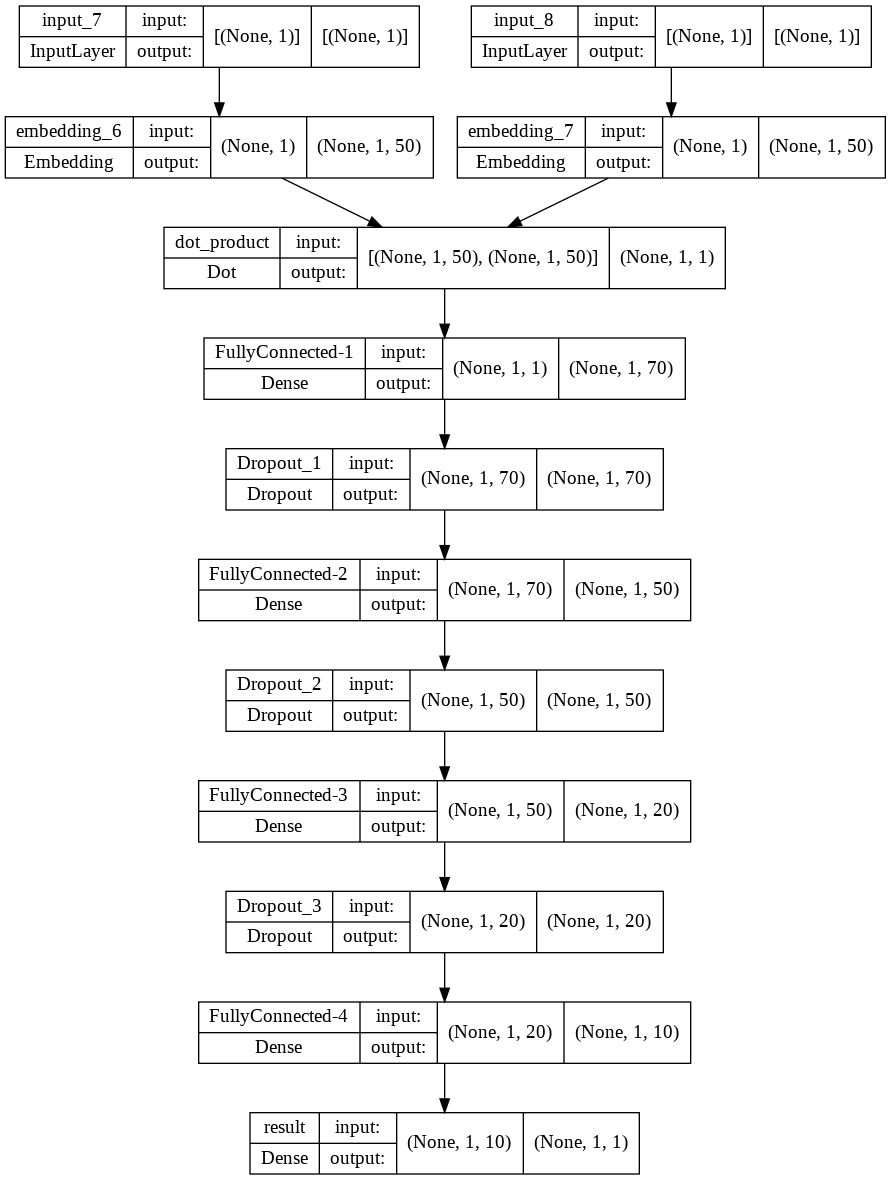

In [ ]:
tf.keras.utils.plot_model(fullmodel,show_shapes=True)

In [ ]:
import collections
ANIME_EMBEDDING_LIST = []
ANIME_EMBED_MAP = collections.defaultdict()
for _id in unique_anime_ids:
    emb = anime_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    ANIME_EMBEDDING_LIST.insert(_id, val)
    ANIME_EMBED_MAP[_id] = val

In [ ]:
TEST_USER_ID = 7
user_embedding = recNN()[1].predict([TEST_USER_ID]).reshape(1,-1)[0]

In [ ]:
knn_train_label=unique_anime_ids
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(ANIME_EMBEDDING_LIST, knn_train_label)

def recommend_anime(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['anime_id'])
    return df_indices.merge(anime_raw.anime_id,on='anime_id',how='inner',suffixes=['_u', '_m'])
  
recommend_anime(user_embedding)

,anime_id
0,942
1,901
2,602
3,1001
4,1044
5,427
6,132
7,258
8,472


Possiamo ora generare delle raccomandazione per un utente!

In [ ]:
user_embedding = user_model.predict([7]).reshape(1,-1)[0]

In [ ]:
anime_raw.name[anime_raw.anime_id.isin(animeenc.inverse_transform(recommend_anime(user_embedding).anime_id))]

365                                               Paprika
588                                       Dragon Ball Kai
721     Code Geass: Boukoku no Akito 2 - Hikisakareshi...
760                                            Elfen Lied
1333                   Bleach Movie 1: Memories of Nobody
2202        One Piece Movie 2: Nejimaki-jima no Daibouken
3564                                 Seiken no Blacksmith
4049                                 Astarotte no Omocha!
Name: name, dtype: object